# Metrics of th breast cancer dataset using different optimizers

In [1]:
import cv2
import mahotas
import numpy as np
import joblib as jb
import pickle as pk
import seaborn as sns
import matplotlib.pyplot as plt

from os import listdir
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import Isomap
from sklearn.model_selection import train_test_split
from collections import Counter

from sklearn.metrics import f1_score, recall_score, precision_score
from sklearn.metrics import confusion_matrix

from sklearn.neural_network import MLPClassifier
from neuralNetwork.perceptron_qpso import perceptron 
from neuralNetwork.perceptron_pso import perceptron_pso
from neuralNetwork.perceptron_pso_bound import perceptron_pso_bound  

In [2]:
#----------------
#Global variables
#----------------

root_path = './dataset2/'
#train_path = 'seg_train/seg_train/'
#test_path = 'seg_test/seg_test/'
#pred_path = 'seg_pred/seg_pred/'

# Dataset classes: buildings, forest, glacier, mountain, sea, street
data_clases = np.array(['cloudy', 
						'rain', 
						'shine', 
						'sunrise'])
IMG_HEIGHT = 150
IMG_WIDTH = 150

#---------------------------------
# Extract Global features
#---------------------------------
bins = 4 

# feature-descriptor-1: Hu Moments
def fd_hu_moments(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    feature = cv2.HuMoments(cv2.moments(image)).flatten()
    return feature

# feature-descriptor-2: Haralick Texture
def fd_haralick(image):
    # convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # compute the haralick texture feature vector
    haralick = mahotas.features.haralick(gray).mean(axis=0)
    # return the result
    return haralick

# feature-descriptor-3: Color Histogram
def fd_histogram(image, mask=None):
    # convert the image to HSV color-space
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    # compute the color histogram
    hist  = cv2.calcHist([image], [0, 1, 2], None, [bins, bins, bins], [0, 256, 0, 256, 0, 256])
    # normalize the histogram
    cv2.normalize(hist, hist)
    # return the histogram
    return hist.flatten()

#---------------------------------
# prepare training and testing set
#---------------------------------

X_train_aux = []
y_train_aux = []

for c in range(len(data_clases)):
	for filename in listdir(root_path + data_clases[c] + '/'):
		# load image
		img_data = cv2.imread(root_path + data_clases[c] + '/' + filename) 
		img_data = cv2.resize(img_data, (IMG_HEIGHT, IMG_WIDTH))
        # Global Feature extraction
		fv_hu_moments = fd_hu_moments(img_data)
		#print(fv_hu_moments.shape)
		fv_haralick = fd_haralick(img_data)
		#print(fv_haralick.shape)        
		fv_histogram  = fd_histogram(img_data)
		#print(fv_histogram.shape)
		# Concatenate global features
		global_feature = np.hstack([fv_histogram, fv_haralick, fv_hu_moments])
		X_train_aux.append(global_feature)
		y_train_aux.append(c)
		print('> loaded %s %s' % (filename, img_data.shape))
		print('> global features %s %s' % (filename, global_feature.shape))

# convert to array
X_train_aux = np.array(X_train_aux)
y_train_aux = np.array(y_train_aux)

# normalize data
#X_train_aux = X_train_aux / 255

print('X_train shape: ', X_train_aux.shape)
print('y_train shape: ', y_train_aux.shape)

> loaded cloudy1.jpg (150, 150, 3)
> global features cloudy1.jpg (84,)
> loaded cloudy10.jpg (150, 150, 3)
> global features cloudy10.jpg (84,)
> loaded cloudy100.jpg (150, 150, 3)
> global features cloudy100.jpg (84,)
> loaded cloudy101.jpg (150, 150, 3)
> global features cloudy101.jpg (84,)
> loaded cloudy102.jpg (150, 150, 3)
> global features cloudy102.jpg (84,)
> loaded cloudy103.jpg (150, 150, 3)
> global features cloudy103.jpg (84,)
> loaded cloudy104.jpg (150, 150, 3)
> global features cloudy104.jpg (84,)
> loaded cloudy105.jpg (150, 150, 3)
> global features cloudy105.jpg (84,)
> loaded cloudy106.jpg (150, 150, 3)
> global features cloudy106.jpg (84,)
> loaded cloudy107.jpg (150, 150, 3)
> global features cloudy107.jpg (84,)
> loaded cloudy108.jpg (150, 150, 3)
> global features cloudy108.jpg (84,)
> loaded cloudy109.jpg (150, 150, 3)
> global features cloudy109.jpg (84,)
> loaded cloudy11.jpg (150, 150, 3)
> global features cloudy11.jpg (84,)
> loaded cloudy110.jpg (150, 150,

In [3]:
# normalize data (0,1)
t = MinMaxScaler()
t.fit(X_train_aux)
X_train_aux = t.transform(X_train_aux)

embedding = Isomap(n_components=42, n_neighbors=100)
X_transformed = embedding.fit_transform(X_train_aux)
print ('Shape of X_train transformed: ', X_transformed.shape)

X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(X_transformed, y_train_aux, test_size=0.3, random_state=100)
print(f"Training target statistics: {Counter(y_train_bal)}")
print(f"Testing target statistics: {Counter(y_test_bal)}")

# Global variables
X_sample = len(X_train_bal)
X_input = len(X_train_bal[1])
X_class = len(np.unique(y_train_bal))

X_train = X_train_bal
y_train = y_train_bal
X_test = X_test_bal
y_test = y_test_bal


Shape of X_train transformed:  (1122, 42)
Training target statistics: Counter({3: 253, 0: 196, 2: 179, 1: 157})
Testing target statistics: Counter({0: 104, 3: 104, 2: 72, 1: 57})


## QDPSO

### All training

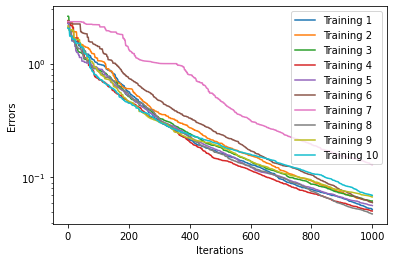

In [4]:
y_qdpso = np.load('mcw_metric_113_100_1000_42_qdpso.npy')

x_qdpso = np.array(range(len(y_qdpso[0])))

for i in range(len(y_qdpso)):
    lab = "Training " + str(i+1)
    plt.plot(x_qdpso, y_qdpso[i], label = lab)
#plt.title("The Loss of QDPSO During Differents Training")
plt.ylabel("Errors")
plt.xlabel("Iterations")
plt.legend()
plt.yscale('log')
#plt.xscale('log')
plt.show()

In [5]:
qdpso_cost = []
for i in range(len(y_qdpso)):
    qdpso_cost.append(y_qdpso[i][len(y_qdpso[0]) - 1])

qdpso_cost = np.array(qdpso_cost)
mean_qdpso = np.mean(qdpso_cost)
std_qdpso = np.std(qdpso_cost)
worst_qdpso = np.max(qdpso_cost)
best_qdpso = np.min(qdpso_cost) 
print("Worst: ", worst_qdpso, " Mean: ", mean_qdpso, ' Best: ', best_qdpso, " Std: ", std_qdpso)
print("Best loss during the training in: ", (qdpso_cost.tolist()).index(best_qdpso) + 1)


Worst:  0.1298100627174946  Mean:  0.06564436780737326  Best:  0.04776985609880383  Std:  0.022393575849629054
Best loss during the training in:  8


### Best training

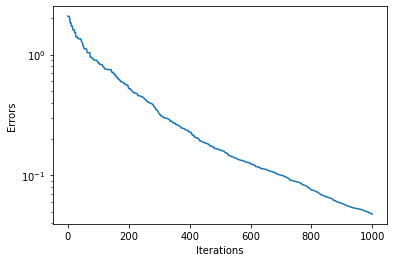

In [6]:
y_qdpso_best = y_qdpso[(qdpso_cost.tolist()).index(best_qdpso)]
x_qdpso_best = np.array(range(len(y_qdpso_best)))
plt.plot(x_qdpso_best, y_qdpso_best)
#plt.title("The Best Loss of QDPSO Durinng the Training")
plt.ylabel("Errors")
plt.xlabel("Iterations")
plt.yscale('log')
plt.show()


### Confusion matrix

In [7]:
qdpso_model_load = np.load('mcw_gBest_113_100_1000_42_qdpso.npy')
nn_qdpso = perceptron(X_sample, X_input, X_class)
y_test_qdpso = np.argmax(nn_qdpso.forward(X_test, qdpso_model_load), axis=1)
cf_matrix_qdpso = confusion_matrix(y_test, y_test_qdpso)
print(cf_matrix_qdpso)
print("F1 score weighted: ", f1_score(y_test, y_test_qdpso, average='weighted'))
print("Recall score weighted: ", recall_score(y_test, y_test_qdpso, average='weighted'))
print("Precision score weighted: ", precision_score(y_test, y_test_qdpso, average='weighted'))

[[90  7  6  1]
 [13 44  0  0]
 [ 3  1 65  3]
 [ 2  0  7 95]]
F1 score weighted:  0.8725820085879483
Recall score weighted:  0.8724035608308606
Precision score weighted:  0.8744671088884739


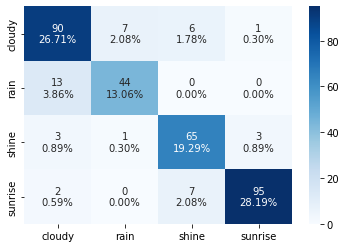

In [8]:
#group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix_qdpso.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix_qdpso.flatten()/np.sum(cf_matrix_qdpso)]

labels = [f"{v1}\n{v2}" for v1, v2 in #\n{v3} , v3
          zip(group_counts, group_percentages)] #group_names,

labels = np.asarray(labels).reshape(4,4)

ax = sns.heatmap(cf_matrix_qdpso, annot=labels, fmt='', cmap='Blues')

#ax.set_title('Confusion Matrix of the Breast Dataset with QDPSO\n\n')
#ax.set_xlabel('\nPredicted Values')
#ax.set_ylabel('True Values ')

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['cloudy', 'rain', 'shine', 'sunrise'])
ax.yaxis.set_ticklabels(['cloudy', 'rain', 'shine', 'sunrise'])

## Display the visualization of the Confusion Matrix.
plt.show()

## PSO

### All training

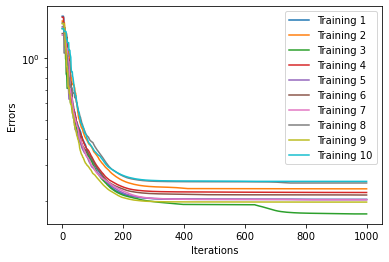

In [9]:

y_pso = np.load('mcw_metric_113_100_1000_42_pso.npy')
y_pso.shape

x_pso = np.array(range(len(y_pso[0])))

for i in range(len(y_pso)):
    lab = "Training " + str(i+1)
    plt.plot(x_pso, y_pso[i], label = lab)

#plt.title("The Loss of PSO During Differents Training")
plt.ylabel("Errors")
plt.xlabel("Iterations")
plt.legend()
#plt.xscale('log')
plt.yscale('log')
plt.show()

In [10]:
pso_cost = []
for i in range(len(y_pso)):
    pso_cost.append(y_pso[i][len(y_pso[0]) - 1])
#print(y_qdpso[0])
#print(qdpso_cost)
pso_cost = np.array(pso_cost)
mean_pso = np.mean(pso_cost)
std_pso = np.std(pso_cost)
worst_pso = np.max(pso_cost)
best_pso = np.min(pso_cost) 
print("Worst: ", worst_pso, " Mean: ", mean_pso, " Best: ", best_pso,"Std: ", std_pso)
print("Best loss during the training in: ", (pso_cost.tolist()).index(best_pso) + 1)

Worst:  0.24917686246059711  Mean:  0.21359032631205657  Best:  0.17275385325608078 Std:  0.021875903140952918
Best loss during the training in:  3


### Best training

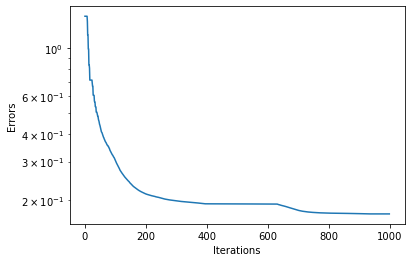

In [11]:
y_pso_best = y_pso[(pso_cost.tolist()).index(best_pso)]
x_pso_best = np.array(range(len(y_pso_best)))
plt.plot(x_pso_best, y_pso_best)
#plt.title("The Best Loss of PSO Durinng the Training")
plt.ylabel("Errors")
plt.xlabel("Iterations")
plt.yscale('log')
plt.show()

### Confusion Matrix

In [12]:
pso_model_load = np.load('mcw_gBest_113_100_1000_42_pso.npy')
nn_pso = perceptron_pso(X_sample, X_input, X_class)
y_test_pso = np.argmax(nn_pso.forward(X_test, pso_model_load), axis=1)
cf_matrix_pso = confusion_matrix(y_test, y_test_pso)
print(cf_matrix_pso)
print("F1 score weighted: ", f1_score(y_test, y_test_pso, average='weighted'))
print("Recall score weighted: ", recall_score(y_test, y_test_pso, average='weighted'))
print("Precision score weighted: ", precision_score(y_test, y_test_pso, average='weighted'))

[[88  9  6  1]
 [10 44  3  0]
 [ 3  1 66  2]
 [ 1  0  8 95]]
F1 score weighted:  0.8699746864442254
Recall score weighted:  0.8694362017804155
Precision score weighted:  0.8731135703837624


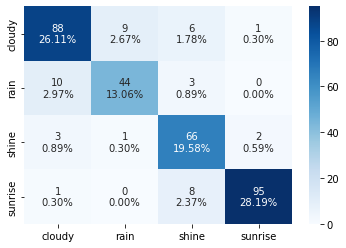

In [13]:
#group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix_pso.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix_pso.flatten()/np.sum(cf_matrix_pso)]

labels = [f"{v1}\n{v2}" for v1, v2 in #\n{v3} , v3
          zip(group_counts, group_percentages)] #group_names,

labels = np.asarray(labels).reshape(4,4)

ax = sns.heatmap(cf_matrix_pso, annot=labels, fmt='', cmap='Blues')

#ax.set_title('Confusion Matrix of the Breast Dataset with PSO\n\n')
#ax.set_xlabel('\nPredicted Values')
#ax.set_ylabel('True Values ')

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['cloudy', 'rain', 'shine', 'sunrise'])
ax.yaxis.set_ticklabels(['cloudy', 'rain', 'shine', 'sunrise'])

## Display the visualization of the Confusion Matrix.
plt.show()

## PSO_Bound

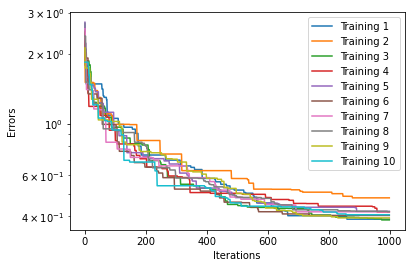

In [14]:
y_pso_bound = np.load('mcw_metric_113_100_1000_42_pso_bound.npy')
y_pso_bound.shape

x_pso_bound = np.array(range(len(y_pso_bound[0])))

for i in range(len(y_pso_bound)):
    lab = "Training " + str(i+1)
    plt.plot(x_pso_bound, y_pso_bound[i], label = lab)

#plt.title("The Loss of PSO_bound During Differents Training")
plt.ylabel("Errors")
plt.xlabel("Iterations")
plt.legend()
plt.yscale('log')
plt.show()

In [15]:
pso_bound_cost = []
for i in range(len(y_pso_bound)):
    pso_bound_cost.append(y_pso_bound[i][len(y_pso_bound[0]) - 1])

pso_bound_cost = np.array(pso_bound_cost)
mean_pso_bound = np.mean(pso_bound_cost)
std_pso_bound = np.std(pso_bound_cost)
worst_pso_bound = np.max(pso_bound_cost) 
best_pso_bound = np.min(pso_bound_cost)
print("Worst: ", worst_pso_bound, " Mean: ", mean_pso_bound," Best: ", best_pso_bound, " Std: ", std_pso_bound)
print("Best loss during the training in: ", (pso_bound_cost.tolist()).index(best_pso_bound) + 1)

Worst:  0.4804440144858002  Mean:  0.4136102744541791  Best:  0.3862467234504583  Std:  0.025425481199983998
Best loss during the training in:  3


### Best training

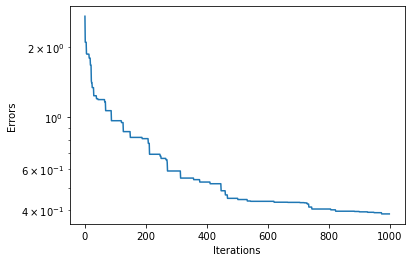

In [16]:
y_pso_bound_best = y_pso_bound[(pso_bound_cost.tolist()).index(best_pso_bound)]
x_pso_bound_best = np.array(range(len(y_pso_bound_best)))
plt.plot(x_pso_bound_best, y_pso_bound_best)
#plt.title("The Best Loss of PSO_bound Durinng the Training")
plt.ylabel("Errors")
plt.xlabel("Iterations")
plt.yscale('log')
plt.show()

### Confusion Matrix

In [17]:
pso_bound_model_load = np.load('mcw_gBest_113_100_1000_42_pso_bound.npy')
nn_pso_bound = perceptron_pso_bound(X_sample, X_input, X_class)
y_test_pso_bound = np.argmax(nn_pso_bound.forward(X_test, pso_model_load), axis=1)
cf_matrix_pso_bound = confusion_matrix(y_test, y_test_pso_bound)
print(cf_matrix_pso_bound)
print("F1 score weighted: ", f1_score(y_test, y_test_pso_bound, average='weighted'))
print("Recall score weighted: ", recall_score(y_test, y_test_pso_bound, average='weighted'))
print("Precision score weighted: ", precision_score(y_test, y_test_pso_bound, average='weighted'))

[[88  9  6  1]
 [10 44  3  0]
 [ 3  1 66  2]
 [ 1  0  8 95]]
F1 score weighted:  0.8699746864442254
Recall score weighted:  0.8694362017804155
Precision score weighted:  0.8731135703837624


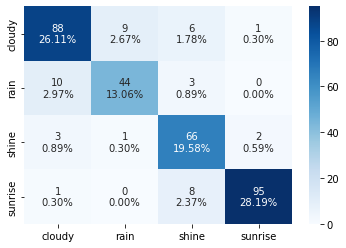

In [18]:
#group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix_pso_bound.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix_pso_bound.flatten()/np.sum(cf_matrix_pso_bound)]

labels = [f"{v1}\n{v2}" for v1, v2 in #\n{v3} , v3
          zip(group_counts, group_percentages)] #group_names,

labels = np.asarray(labels).reshape(4,4)

ax = sns.heatmap(cf_matrix_pso_bound, annot=labels, fmt='', cmap='Blues')

#ax.set_title('Confusion Matrix of the Breast Dataset with PSO_bound\n\n')
#ax.set_xlabel('\nPredicted Values')
#ax.set_ylabel('True Values ')

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['cloudy', 'rain', 'shine', 'sunrise'])
ax.yaxis.set_ticklabels(['cloudy', 'rain', 'shine', 'sunrise'])

## Display the visualization of the Confusion Matrix.
plt.show()

## The best loss of the Metaheuristic-based optimizers

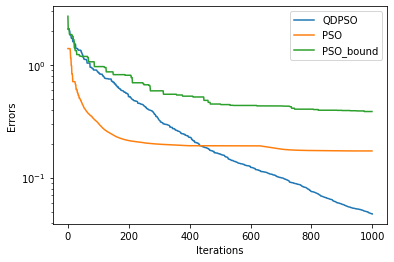

In [19]:
plt.plot(x_qdpso_best, y_qdpso_best, label = 'QDPSO')
plt.plot(x_pso_best, y_pso_best, label = 'PSO')
plt.plot(x_pso_bound_best, y_pso_bound_best, label = 'PSO_bound')
#plt.title("The Best Loss of the Metaheuristic-based Optimizers")
plt.ylabel("Errors")
plt.xlabel("Iterations")
plt.legend()
plt.yscale('log')
plt.show()

## Adam

### All training

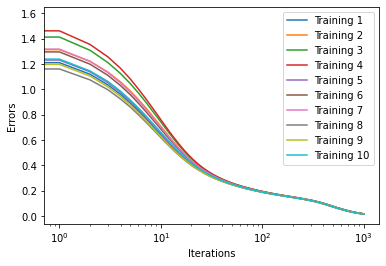

In [20]:
with open ('mcw_metric_113_100_1000_42_adam', 'rb') as temp:
    y_adam = pk.load(temp)

x_adam = np.array(range(len(y_adam[0])))

for i in range (len(y_adam)):
    lab = "Training " + str(i+1)
    plt.plot(x_adam, y_adam[i], label = lab)

#plt.title("The Loss of Adam During Differents Training")
plt.ylabel("Errors")
plt.xlabel("Iterations")
plt.legend()
plt.xscale('log')
#plt.yscale('log')
plt.show()

In [21]:
adam_cost = []
for i in range(len(y_adam)):
    adam_cost.append(y_adam[i][len(y_adam[0]) - 1])

adam_cost = np.array(adam_cost)
mean_adam = np.mean(adam_cost)
std_adam = np.std(adam_cost)
worst_adam = np.max(adam_cost) 
best_adam = np.min(adam_cost)
print("Worst: ", worst_adam, " Mean: ", mean_adam, " Best: ", best_adam, " Std: ", std_adam)
print("Best loss during the training in: ", (adam_cost.tolist()).index(best_adam) + 1)


Worst:  0.017913555119262972  Mean:  0.016620807637211597  Best:  0.015571605358368623  Std:  0.0006986269410499766
Best loss during the training in:  10


### Best training

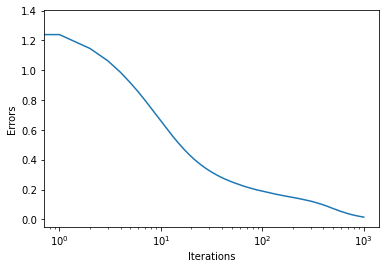

In [22]:
adam_loss_load = y_adam[(adam_cost.tolist()).index(best_adam)]
plt.plot(adam_loss_load)
#plt.title("The Best Loss of Adam Durinng the Training")
plt.ylabel("Errors")
plt.xlabel("Iterations")
plt.xscale('log')
plt.show()

### Confussion Matrix

In [23]:
adam_model_load = jb.load('mcw_model_113_100_1000_42_adam.sav')
y_test_adam = adam_model_load.predict(X_test)
cf_matrix_adam = confusion_matrix(y_test, y_test_adam)
print(cf_matrix_adam)
print("F1 score weighted: ", f1_score(y_test, y_test_adam, average='weighted'))
print("Recall score weighted: ", recall_score(y_test, y_test_adam, average='weighted'))
print("Precision score weighted: ", precision_score(y_test, y_test_adam, average='weighted'))

[[87 12  5  0]
 [ 8 48  1  0]
 [ 3  1 65  3]
 [ 2  1  6 95]]
F1 score weighted:  0.876349109064625
Recall score weighted:  0.8753709198813057
Precision score weighted:  0.8789453399640877


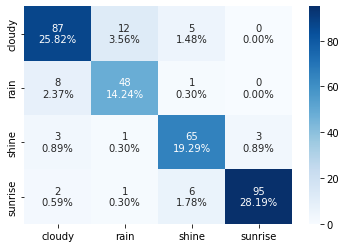

In [24]:
#group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix_adam.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix_adam.flatten()/np.sum(cf_matrix_adam)]

labels = [f"{v1}\n{v2}" for v1, v2 in #\n{v3} , v3
          zip(group_counts, group_percentages)] #group_names,

labels = np.asarray(labels).reshape(4,4)

ax = sns.heatmap(cf_matrix_adam, annot=labels, fmt='', cmap='Blues')

#ax.set_title('Confusion Matrix of the Breast Dataset with Adam\n\n')
#ax.set_xlabel('\nPredicted Values')
#ax.set_ylabel('True Values ')

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['cloudy', 'rain', 'shine', 'sunrise'])
ax.yaxis.set_ticklabels(['cloudy', 'rain', 'shine', 'sunrise'])

## Display the visualization of the Confusion Matrix.
plt.show()

## L-BFGS

In [25]:
with open ('mcw_metric_113_100_1000_42_lbfgs', 'rb') as temp:
    y_lbfgs = pk.load(temp)

lbfgs_cost = np.array(y_lbfgs)
mean_lbfgs = np.mean(lbfgs_cost)
std_lbfgs = np.std(lbfgs_cost)
worst_lbfgs = np.max(lbfgs_cost) 
best_lbfgs = np.min(lbfgs_cost)
print("Worst: ", worst_lbfgs, "Mean: ", mean_lbfgs, ' Best: ', best_lbfgs, " Std: ", std_lbfgs)
print("Best loss during the training in: ", (lbfgs_cost.tolist()).index(best_lbfgs) + 1)

Worst:  0.0017745426716138876 Mean:  0.0015510316804375572  Best:  0.001337334136139416  Std:  0.00012634091433687175
Best loss during the training in:  1


### Confusion Matrix

In [26]:
lbfgs_model_load = jb.load('mcw_model_113_100_1000_42_lbfgs.sav')
y_test_lbfgs = lbfgs_model_load.predict(X_test)
cf_matrix_lbfgs = confusion_matrix(y_test, y_test_lbfgs)
print(cf_matrix_lbfgs)
print("F1 score weighted: ", f1_score(y_test, y_test_lbfgs, average='weighted'))
print("Recall score weighted: ", recall_score(y_test, y_test_lbfgs, average='weighted'))
print("Precision score weighted: ", precision_score(y_test, y_test_lbfgs, average='weighted'))

[[86 12  5  1]
 [ 8 48  1  0]
 [ 3  1 65  3]
 [ 0  0  7 97]]
F1 score weighted:  0.8788944166963679
Recall score weighted:  0.8783382789317508
Precision score weighted:  0.8811271000065747


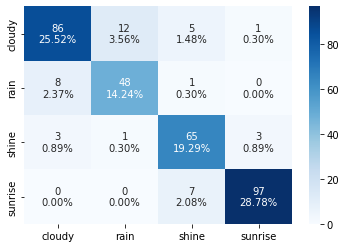

In [27]:
#group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix_lbfgs.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix_lbfgs.flatten()/np.sum(cf_matrix_lbfgs)]

labels = [f"{v1}\n{v2}" for v1, v2 in #\n{v3} , v3
          zip(group_counts, group_percentages)] #group_names,

labels = np.asarray(labels).reshape(4,4)

ax = sns.heatmap(cf_matrix_lbfgs, annot=labels, fmt='', cmap='Blues')

#ax.set_title('Confusion Matrix of the Breast Dataset with L-BFGS\n\n')
#ax.set_xlabel('\nPredicted Values')
#ax.set_ylabel('True Values ')

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['cloudy', 'rain', 'shine', 'sunrise'])
ax.yaxis.set_ticklabels(['cloudy', 'rain', 'shine', 'sunrise'])

## Display the visualization of the Confusion Matrix.
plt.show()

## SGD

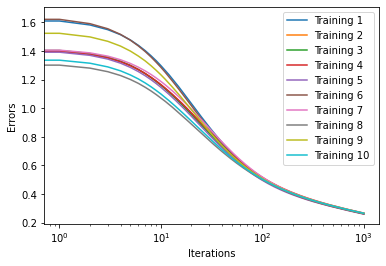

In [28]:
with open ('mcw_metric_113_100_1000_42_sgd', 'rb') as temp:
    y_sgd = pk.load(temp)

x_sgd = np.array(range(len(y_sgd[0])))

for i in range (len(y_sgd)):
    lab = "Training " + str(i+1)
    plt.plot(x_sgd, y_sgd[i], label = lab)

#plt.title("The Loss of SGD During Differents Training")
plt.ylabel("Errors")
plt.xlabel("Iterations")
plt.legend()
plt.xscale('log')
plt.show()

In [29]:
sgd_cost = []
for i in range(len(y_sgd)):
    sgd_cost.append(y_sgd[i][len(y_sgd[0]) - 1])

sgd_cost = np.array(sgd_cost)
mean_sgd = np.mean(sgd_cost)
std_sgd = np.std(sgd_cost)
worst_sgd = np.max(sgd_cost) 
best_sgd = np.min(sgd_cost)
print(" Worst: ", worst_sgd, " Mean: ", mean_sgd, " Best: ", best_sgd, " Std: ", std_sgd)
print("Best loss during the training in: ", (sgd_cost.tolist()).index(best_sgd) + 1)

 Worst:  0.2672122447127156  Mean:  0.2640108776744514  Best:  0.25981861567814746  Std:  0.002182359751903479
Best loss during the training in:  5


### Best Training

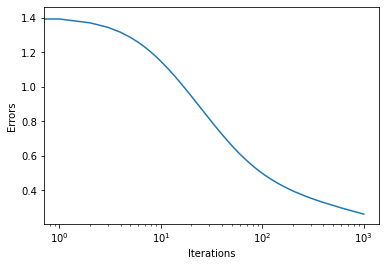

In [30]:
sgd_loss_load = y_sgd[(sgd_cost.tolist()).index(best_sgd)]
plt.plot(sgd_loss_load)
#plt.title("The Best Loss of SGD Durinng the Training")
plt.ylabel("Errors")
plt.xlabel("Iterations")
plt.xscale('log')
plt.show()

### Confusion Matrix

In [31]:
sgd_model_load = jb.load('mcw_model_113_100_1000_42_sgd.sav')
y_test_sgd = sgd_model_load.predict(X_test)
cf_matrix_sgd = confusion_matrix(y_test, y_test_sgd)
print(cf_matrix_sgd)
print("F1 score weighted: ", f1_score(y_test, y_test_sgd, average='weighted'))
print("Recall score weighted: ", recall_score(y_test, y_test_sgd, average='weighted'))
print("Precision score weighted: ", precision_score(y_test, y_test_sgd, average='weighted'))

[[90  8  6  0]
 [ 8 49  0  0]
 [ 3  1 68  0]
 [ 2  1  6 95]]
F1 score weighted:  0.8970548666650683
Recall score weighted:  0.8961424332344213
Precision score weighted:  0.9003346274736334


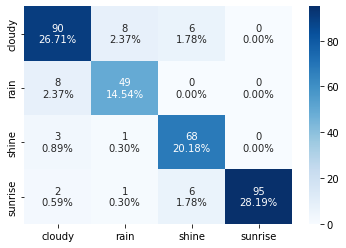

In [32]:
#group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix_sgd.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix_sgd.flatten()/np.sum(cf_matrix_sgd)]

labels = [f"{v1}\n{v2}" for v1, v2 in #\n{v3} , v3
          zip(group_counts, group_percentages)] #group_names,

labels = np.asarray(labels).reshape(4,4)

ax = sns.heatmap(cf_matrix_sgd, annot=labels, fmt='', cmap='Blues')

#ax.set_title('Confusion Matrix of the Breast Dataset with SGD\n\n')
#ax.set_xlabel('\nPredicted Values')
#ax.set_ylabel('True Values ')

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['cloudy', 'rain', 'shine', 'sunrise'])
ax.yaxis.set_ticklabels(['cloudy', 'rain', 'shine', 'sunrise'])

## Display the visualization of the Confusion Matrix.
plt.show()

## The best loss of the Gradient-based optimizers

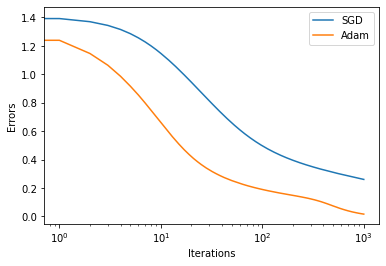

In [33]:
plt.plot(sgd_loss_load, label = 'SGD')
plt.plot(adam_loss_load, label = 'Adam')
#plt.title("The Best Loss of the Gadient-based Optimizers")
plt.ylabel("Errors")
plt.xlabel("Iterations")
plt.legend()
plt.xscale('log')
plt.show()

## The best loss of the Gradient-based and Metaheuristic-based optimizers

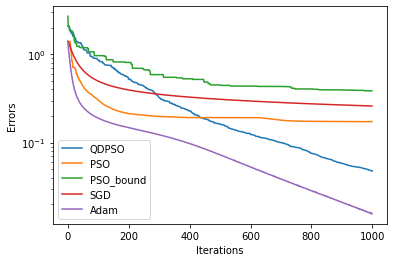

In [34]:
plt.plot(x_qdpso_best, y_qdpso_best, label = 'QDPSO')
plt.plot(x_pso_best, y_pso_best, label = 'PSO')
plt.plot(x_pso_bound_best, y_pso_bound_best, label = 'PSO_bound')

plt.plot(sgd_loss_load, label = 'SGD')
plt.plot(adam_loss_load, label = 'Adam')
#plt.title("The Best Loss of the All Optimizers")
plt.ylabel("Errors")
plt.xlabel("Iterations")
plt.legend()
plt.yscale('log')
#plt.xscale('log')
plt.show()